# Reference points


## Question

Do reference points have comparable positions among all structures?

## Experiment

* Centroid: Distances of centroids with respect to reference centroid
* Hinge/DFG region: Distances of refe
* Front region

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from itertools import combinations
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import pandas as pd
import scipy

sys.path.append('../..')
from kinsim_structure.auxiliary import KlifsMoleculeLoader
from kinsim_structure.encoding import SpatialFeatures

In [4]:
pd.set_option('display.max_rows', 100)

## IO paths

In [5]:
path_to_kinsim = Path('/') / 'home' / 'dominique' / 'Documents' / 'Projects' / 'kinsim_structure'
path_to_data = Path('/') / 'home' / 'dominique' / 'Documents' / 'data' / 'kinsim' / '20190724_full'

path_to_results = path_to_kinsim / 'examples'/ 'results'

metadata_path = path_to_data / 'postprocessed' / 'klifs_metadata_postprocessed.csv'

## Load metadata

In [6]:
klifs_metadata = pd.read_csv(metadata_path, index_col=0)

## Reference structure `2wo6_A`

In [7]:
klifs_metadata[klifs_metadata.pdb_id == '2wo6']

,metadata_index,kinase,family,groups,pdb_id,chain,alternate_model,species,ligand_orthosteric_name,ligand_orthosteric_pdb_id,...,ac_helix,rmsd1,rmsd2,qualityscore,pocket,resolution,missing_residues,missing_atoms,full_ifp,code
1406,2818,DYRK1A,DYRK,CMGC,2wo6,B,B,Human,N-(5-{[(2S)-4-amino-2-(3-chlorophenyl)butanoyl...,D15,...,in,0.775,2.11,8.0,SLIGKGSFGQVVKVAIKIIQAQIEVRLLELMNYYIVHLKRHCLVFE...,2.5,0,0,0000000000000010000001000000100000010000000000...,HUMAN/DYRK1A/2wo6_chainB_altB


In [8]:
metadata_id_2wo6 = klifs_metadata[klifs_metadata.pdb_id == '2wo6'].index[0]
metadata_id_2wo6

1406

## Get reference points

Get the coordinates for 4 reference points per structure.

In [9]:
def get_reference_points(klifs_metadata):
    
    reference_points = {}

    for index, row in klifs_metadata.iterrows():

        # Load structural data
        ml = KlifsMoleculeLoader(klifs_metadata_entry=row)
        
        # Calculate spatial features
        spatial = SpatialFeatures()
        spatial.from_molecule(ml.molecule)

        # Get reference points and save to dict with metadata index as key
        reference_points[row.metadata_index] = spatial.reference_points
        
    # Concatenate data from all structures
    reference_points = pd.concat(reference_points, axis=0)
    reference_points.index.set_names(['id', 'coordinate'], inplace=True)
    
    return reference_points

In [10]:
reference_points = pd.read_csv(
    path_to_results / 'reference_points' / 'coordinates_reference_points.csv',
    index_col=['id', 'coordinate']
)
print(reference_points.shape)
reference_points.head()

(11634, 4)


centroid  hinge_region  dfg_region  front_pocket
id    coordinate                                                   
2886  x            1.026635      1.976200    7.410200     -0.735833
      y           20.789879     21.758433   20.057467     15.892600
      z           36.404018     41.804733   33.520733     39.503467
10043 x            1.047804      2.009300    7.346733      0.313867
      y           21.004120     21.944700   20.813700     16.005333

## Get hinge and DFG residues

Get coordinates for the 3 residues of the hinge and DFG region

In [11]:
def get_hinge_dfg_ca(klifs_metadata):
    
    hinge_residues = [46, 47, 48]
    dfg_residues = [81, 82, 83]
    
    hinge_dfg_ca = {}

    for index, row in klifs_metadata.iterrows():

        # Load structural data
        ml = KlifsMoleculeLoader(klifs_metadata_entry=row)
        molecule = ml.molecule
        
        # Define with atoms to select (CA atoms for hinge/DFG region)
        condition = (molecule.df.atom_name == 'CA') & (molecule.df.klifs_id.isin(hinge_residues+dfg_residues))

        # Get coordinates and format DataFrame: rows = coordinates and columns = residue IDs
        coordinates = molecule.df[condition]['x y z klifs_id'.split()]
        coordinates.set_index('klifs_id', drop=True, inplace=True)
        coordinates = coordinates.transpose()
        coordinates.columns.set_names(['residues'], inplace=True)
        
        hinge_dfg_ca[row.metadata_index] = coordinates
        
    # Concatenate data from all structures
    hinge_dfg_ca = pd.concat(hinge_dfg_ca, axis=0)
    hinge_dfg_ca.index.set_names(['id', 'coordinate'], inplace=True)
    
    # Split DataFrame by region
    hinge_dfg_ca = {
     'hinge': hinge_dfg_ca.loc[:, hinge_residues],
     'dfg':  hinge_dfg_ca.loc[:, dfg_residues]
    }
    
    # Concatenate again with multi-index column (region, residues)
    hinge_dfg_ca = pd.concat(hinge_dfg_ca.values(), axis=1, keys=hinge_dfg_ca.keys())
    
    return hinge_dfg_ca

In [12]:
hinge_dfg_ca = get_hinge_dfg_ca(klifs_metadata)

In [13]:
hinge_dfg_ca.to_csv(path_to_results / 'reference_points' / 'coordinates_hinge_dfg_ca.csv')

In [14]:
hinge_dfg_ca.head()

hinge                        dfg                  
residues               46       47       48       81       82       83
id    coordinate                                                      
2886  x            0.4799  -0.3060  -3.7619   1.5806   2.8018   5.7823
      y           26.3014  23.3326  21.9317  19.3573  21.5128  19.2963
      z           43.8558  46.1435  45.3376  33.5495  30.6353  30.0596
10043 x            0.2635  -0.1987  -3.5961   1.5488   2.5897   5.8670
      y           25.9876  22.9660  21.3855  19.5079  21.6241  19.7742

## Distance reference points to hinge/DFG region

In [15]:
reference_points.hinge_region.head()

id     coordinate
2886   x              1.976200
       y             21.758433
       z             41.804733
10043  x              2.009300
       y             21.944700
Name: hinge_region, dtype: float64

In [16]:
hinge_dfg_ca.hinge.head()

residues               46       47       48
id    coordinate                           
2886  x            0.4799  -0.3060  -3.7619
      y           26.3014  23.3326  21.9317
      z           43.8558  46.1435  45.3376
10043 x            0.2635  -0.1987  -3.5961
      y           25.9876  22.9660  21.3855

In [17]:
# Get metadata ID
metadata_ids = [i[0] for i in reference_points.groupby(level='id', sort=False)]
metadata_ids[:10]

[2886, 10043, 7046, 843, 815, 859, 816, 807, 832, 829]

### HInge region

In [18]:
distances_hinge = {}

for metadata_id in metadata_ids:
    
    try:
        # Calculate vector between points
        vectors_hinge = hinge_dfg_ca.loc[metadata_id].hinge.sub(
            reference_points.loc[metadata_id].hinge_region, 
            axis=0
        )

        # Calculate vector norm (distance)
        distance_hinge = vectors_hinge.apply(lambda x: scipy.linalg.norm(x), axis=0)
        
    except ValueError:
        print(metadata_id)
        continue
    
    distances_hinge[metadata_id] = distance_hinge

3130
1399
2193
2187
2166
2196
6856
2302


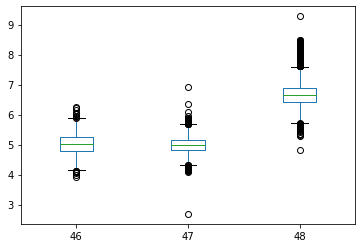

In [19]:
distances_hinge = pd.concat(distances_hinge, axis=0)

data_list = []
residue_id_list = []

for residue_id, data in distances_hinge.groupby(level='residues', sort=False):
    data_list.append(pd.Series(list(data)))
    residue_id_list.append(residue_id)
    
distances_hinge = pd.concat(data_list, axis=1)
distances_hinge.columns = residue_id_list
distances_hinge.plot.box()

In [20]:
distances_hinge[
    (distances_hinge[46] > 6) | (distances_hinge[47] > 6) | (distances_hinge[48] > 8)
].sort_values(by=[48, 47, 46], ascending=False)

,46,47,48
1171,5.757893,6.357279,9.280369
2955,5.100716,5.286227,8.491359
2999,5.056278,5.259119,8.489358
2945,5.061281,5.167992,8.470243
2993,5.238595,5.260629,8.442288
2985,5.094872,5.185707,8.434842
2925,5.138376,5.296392,8.434599
3054,5.166728,5.240510,8.433710
3001,5.140090,5.279955,8.424338
3002,4.947677,5.171685,8.416026


### DFG region

In [21]:
distances_dfg = {}

for metadata_id in metadata_ids:
    
    try:
        # Calculate vector between points
        vectors_dfg = hinge_dfg_ca.loc[metadata_id].dfg.sub(
            reference_points.loc[metadata_id].dfg_region, 
            axis=0
        )

        # Calculate vector norm (distance)
        distance_dfg = vectors_dfg.apply(lambda x: scipy.linalg.norm(x), axis=0)
        
    except ValueError:
        print(metadata_id)
        continue

    distances_dfg[metadata_id] = distance_dfg

4104
4109
9830
1541
1504
9595
6189
8746
2208
3492
4837
2953
3059
5963
1399
3673
2176
2163
2167
2191
2181
2172
2076
274
305
301
254
6125
2678
6410
9021
9051
6057
1362
5993
8663
6990
9564
7590
6938
975
8494
190
7523
407
2278
5021
578
9144
9158
9128
9142
9143
9129
9136
9123
236
209
255
7360
7168
2930
2916
8361
2121
2126
2107
9607
9606
9608
782
2302
8839
9371
9370
2746
8246
3855
3884
3802
3800
3949
3998
3977
3988
3797
3805
8689
3946
8258


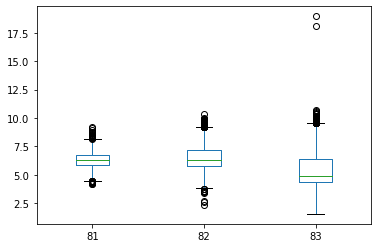

In [22]:
distances_dfg = pd.concat(distances_dfg, axis=0)

data_list = []
residue_id_list = []

for residue_id, data in distances_dfg.groupby(level='residues', sort=False):
    data_list.append(pd.Series(list(data)))
    residue_id_list.append(residue_id)
    
distances_dfg = pd.concat(data_list, axis=1)
distances_dfg.columns = residue_id_list
distances_dfg.plot.box()

In [23]:
distances_dfg[
    (distances_dfg[81] > 8) | (distances_dfg[82] > 8) | (distances_dfg[83] > 10)
].sort_values(by=[83, 82, 81], ascending=False)

,81,82,83
3274,6.861162,7.408181,18.958419
1566,6.987313,6.971888,18.082801
2525,7.098741,10.364892,10.696183
3714,7.340665,9.533544,10.643996
1560,7.467104,9.710361,10.558241
2414,6.483121,9.311586,10.407936
311,6.815534,8.968321,10.355220
2415,6.442536,9.135002,10.340298
2361,7.495201,8.885984,10.217903
1871,7.320866,9.166830,10.141861


## Get centroids

In [24]:
metadata_id_2wo6

1406

In [25]:
centroid_2ow6 = reference_points.loc[metadata_id_2wo6].centroid
centroid_2ow6

coordinate
x     1.156599
y    20.902531
z    36.706228
Name: centroid, dtype: float64

In [26]:
# Distance centroids to reference centroid
centroid_distances = {}

for metadata_id, coordinates in reference_points.centroid.groupby(level='id', sort=False):
    
    centroid_distances[metadata_id] = scipy.linalg.norm(coordinates - centroid_2ow6)

In [27]:
centroid_distances = pd.Series(centroid_distances, name='Distance centroids to reference centroid')

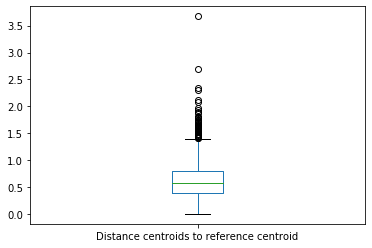

In [28]:
centroid_distances.plot.box()

In [29]:
centroid_distances.sort_values(ascending=False).head(10)

1399    3.673922
2302    2.684748
7169    2.345189
609     2.309152
7537    2.108237
3977    2.081227
2356    1.976416
2357    1.930629
720     1.902867
209     1.880033
Name: Distance centroids to reference centroid, dtype: float64